<a href="https://colab.research.google.com/github/Joocheol/Financial-Engineering/blob/master/20211120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

In [2]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

In [3]:
S0 = 1
K = 1
T = 30/365
r = 0.0
sig = 0.2

M = 1000
N = 100

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [4]:
np.random.seed(1234)

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

$\Delta_0 (S_0-S_1) + \Delta_1 (S_1-S_2) + \Delta_2 (S_2-S_3) + \cdots + \Delta_{T-1} (S_{T-1}-S_T) + \Delta_T S_T$

In [5]:
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = my_input + [premium] + [hedge_cost] + [price]

for j in range(N):
    
    #delta = tf.keras.layers.Dense(32, activation='tanh')(price_set)
    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    # delta = tf.keras.layers.BatchNormalization()(delta)
    # delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    # delta = tf.keras.layers.BatchNormalization()(delta)
    # delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.Dense(1)(delta)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    #info_set = tf.keras.layers.Concatenate()([price, new_price])
    price = new_price


payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(x-K,0), name='payoff')(price)
cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="cum_cost-premium")([cum_cost, premium])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

$\Delta_0 (S_0-S_1) + \Delta_1 (S_1-S_2) + \Delta_2 (S_2-S_3) + \cdots + \Delta_{T-1} (S_{T-1}-S_T) + \Delta_T S_T$

In [6]:
tf.keras.utils.plot_model(model)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.968349 to fit
tcmalloc: large alloc 1304657920 bytes == 0x560d76e60000 @  0x7f0dc93db001 0x7f0dc56721fa 0x7f0dc56722ad 0x7f0dc67fd6df 0x7f0dc6cf4261 0x7f0dc9171468 0x7f0dc9173d53 0x560d73fc5092 0x7f0dc8b26bf7 0x560d73fc512a



In [7]:
premium = bscall(S0,K,T,r,sig) * np.ones([M,1])
cost = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [premium]+[cost]+[SS]
y = np.zeros([M,1])

In [8]:
model.compile(loss='mse', optimizer='adam')

In [9]:
hist = model.fit(x,y, batch_size=32, epochs=100, verbose=True, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 12s 114ms/step - loss: 0.0012 - val_loss: 9.9287e-04
Epoch 2/100
25/25 [==============================] - 1s 24ms/step - loss: 7.9437e-04 - val_loss: 7.2278e-04
Epoch 3/100
25/25 [==============================] - 1s 23ms/step - loss: 5.4419e-04 - val_loss: 5.5186e-04
Epoch 4/100
25/25 [==============================] - 1s 23ms/step - loss: 4.0378e-04 - val_loss: 4.4937e-04
Epoch 5/100
25/25 [==============================] - 1s 23ms/step - loss: 3.2340e-04 - val_loss: 3.8243e-04
Epoch 6/100
25/25 [==============================] - 1s 22ms/step - loss: 2.7733e-04 - val_loss: 3.4939e-04
Epoch 7/100
25/25 [==============================] - 1s 22ms/step - loss: 2.5532e-04 - val_loss: 3.2914e-04
Epoch 8/100
25/25 [==============================] - 1s 22ms/step - loss: 2.4226e-04 - val_loss: 3.1781e-04
Epoch 9/100
25/25 [==============================] - 1s 21ms/step - loss: 2.3575e-04 - val_loss: 3.1122e-04
Epoch 10/100
25/25 [==========

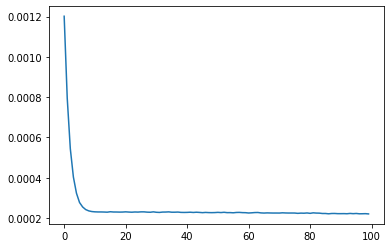

In [10]:
plt.plot(hist.history['loss'])
plt.show()

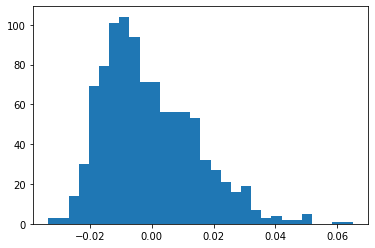

In [11]:
plt.hist(model.predict(x), bins=30)
plt.show()

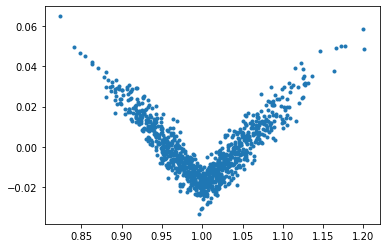

In [12]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()